In [32]:
# 结构信息

In [33]:
import torch
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from networkx.algorithms.bipartite.basic import color
plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
plt.rcParams['axes.unicode_minus']=False #显示负号

In [34]:
dof=5  #结构自由度
dt=0.02 #时间步长度
beta=0.25 
gama=0.5
alpha=0.2 #刚度折减系数

In [35]:
#质量矩阵
m=torch.tensor([5000.0,5000.0,5000.0,5000.0,5000.0])  # kg
M=torch.diag(m)

In [36]:
#刚度矩阵
k=torch.tensor([5e5]*5)  #层间刚度 N/m
K0=torch.tensor([
    [k[0]+k[1],-k[1],0,0,0],
    [-k[1],k[1]+k[2],-k[2],0,0],
    [0,-k[2],k[2]+k[3],-k[3],0],
    [0,0,-k[2],k[3]+k[4],-k[4]],
    [0,0,0,-k[4],k[4]]
])

In [37]:
K_re=torch.tensor([
    [-k[0],k[1],0,0,0],
    [0,-k[1],k[2],0,0],
    [0,0,-k[2],k[3],0],
    [0,0,0,-k[3],k[4]],
    [0,0,0,0,-k[4]]])

In [38]:
zeta = 0.05; w1 = 0.0521; w2 = 0.3513   #定义结构阻尼比
a_coe = 2*w1*w2*zeta/(w1+w2); b_coe = 2*zeta/(w1+w2)
C =a_coe*M + b_coe*K0 #计算瑞利阻尼

In [39]:
# Newmark_beta法计算系数
a0=1/(beta*dt**2)
a1=1/(beta*dt)
a2=1/(2*beta)-1
a3=gama/(beta*dt)
a4=gama/beta-1
a5=(gama/beta-2)*dt/2

In [40]:
L=torch.zeros((dof,2))
L[:,0]=m
L[:,1]=-torch.tensor(([1,0,0,0,0]))

In [41]:
H=torch.zeros((dof*2,dof*2))
H[dof:,:dof]=-torch.inverse(M)@K0
H[:dof,dof:]=torch.eye(dof)
H[dof:,dof:]=-torch.inverse(M)@C

In [42]:
W=torch.zeros((dof*2,2))
W[dof:]=torch.inverse(M)@L

In [43]:
S1=torch.zeros((dof*2,dof*2))
S1[:dof,:dof]=a3*torch.eye(dof)
S1[dof:,:dof]=a0*torch.eye(dof)

In [44]:
S2=torch.zeros((dof*2,dof*2))
S2[:dof,:dof]=a4*torch.eye(dof)
S2[dof:,:dof]=a1*torch.eye(dof)
S2[:dof,dof:]=a5*torch.eye(dof)
S2[dof:,dof:]=a2*torch.eye(dof)

In [45]:
Q1=-torch.inverse((H-S1))@S2@W

In [46]:
Q2=-torch.inverse((H-S1))@W

In [47]:
T=-torch.inverse(H-S1)@(S1+S2@H)

In [48]:
A1_1=Q2
A2_1=T@Q2+Q1
A=torch.stack((A1_1,A2_1))
for i in range(2,600):
    A=torch.cat((A,torch.unsqueeze(T@A[-1],0)),dim=0)
A=torch.flip(A,[0])      

In [49]:
A_nl=A[:,0,:]

In [50]:
# 得到P
acc=pd.read_csv("地震加速度.csv").iloc[1:,1:]  # m/s^2
acc=torch.from_numpy(np.array(acc)).float()
mean=acc.mean()
var=acc.var()
acc=(acc-mean)/pow(var,0.5)

In [51]:
def seq_data_iter(data,batch_size,num_step):
    for i in range(len(data)//batch_size):
        batch_data=data[i*batch_size:i*batch_size+batch_size,:]
        for j in range(num_step,data.shape[1]+1):
            yield batch_data[:,j-num_step:j]

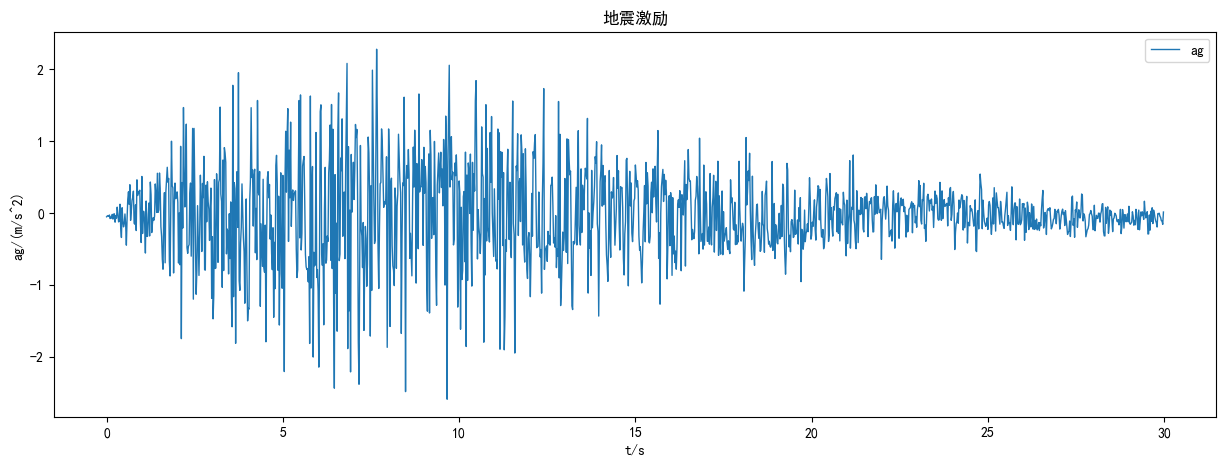

In [52]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,30,0.02),acc[0,:].detach(), label='ag', linewidth=1)
plt.ylabel("ag/(m/s^2)")
plt.xlabel("t/s")
plt.legend(loc='best')
plt.title("地震激励")
plt.show()

In [53]:
class LSTMModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModule, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to("cuda")
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to("cuda")
        out, _ = self.lstm(x, (h0, c0))
        #out = self.fc1(out[:, -1, :])
        out = self.fc1(self.relu(out))
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [54]:
# 单层神经网络，无激活函数
class SCL(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,kernel_A):
        super(SCL,self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,kernel_size,stride=1,bias=False)
        self.conv.weight.data = kernel_A
        self.conv.weight.requires_grad = False
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [55]:
#定义损失函数
def V2Fnl(V,yita):
    V_re=V[:,0,0,:]
    Fnl=yita*k[0]*(V_re**3)
    return Fnl

In [56]:
yita=1000
epochs=500
num_step=1

In [57]:
i=0
for data in seq_data_iter(acc,300,num_step):
    if i==0:
        acc_30steps=data.unsqueeze(2)
    else:
        acc_30steps=torch.cat((acc_30steps,data.unsqueeze(2)),dim=2)
    i+=1
print(acc_30steps.shape)

torch.Size([300, 1, 1500])


In [58]:
acc_train=acc_30steps[:180]
acc_vali=acc_30steps[180:200]
acc_test=acc_30steps[200:]
data_train=acc_train.to("cuda")

In [59]:
get_V_loss=[]
lstm_model=LSTMModule(num_step,90,3,1).to("cuda")
A_kernel=A_nl.unsqueeze(1).permute((1,2,0)).unsqueeze(1)
scl_model=SCL(1,1,(6,600),A_kernel).to("cuda")
loss=nn.MSELoss()
optimizer=optim.Adam(lstm_model.parameters(),lr=0.01,weight_decay=0.98)

In [60]:
timestamp1=time.time()


for i in range(epochs):
    F_nl=torch.zeros_like(data_train).to("cuda")
    optimizer.zero_grad()
    F_nl=lstm_model(data_train.permute((0,2,1)))
    P_nl_total=torch.stack((acc[0:180,(num_step-1):].to("cuda"),F_nl[:,:,0]),dim=2)
    P_tatol=torch.cat((torch.zeros([180,len(A_nl)-1,P_nl_total.shape[2]]).to("cuda"),P_nl_total),dim=1)
    P_tatol=P_tatol.unsqueeze(1).permute(0,1,3,2)
    V_nl=scl_model(P_tatol)
    F_nl_re=V2Fnl(V_nl,yita)
    V_loss=loss(F_nl[:,:,0],F_nl_re)
    V_loss.backward()
    optimizer.step()
    get_V_loss.append(V_loss)
    
timestamp2=time.time()
time_difference = timestamp2 - timestamp1
print("时间差（秒）：", time_difference)

时间差（秒）： 31.141531467437744


In [61]:
df=torch.tensor(get_V_loss).detach().numpy()
df=pd.DataFrame(df)
df.to_csv("get_V_loss.csv")
torch.save(lstm_model, 'get_V_lstm.pth')

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

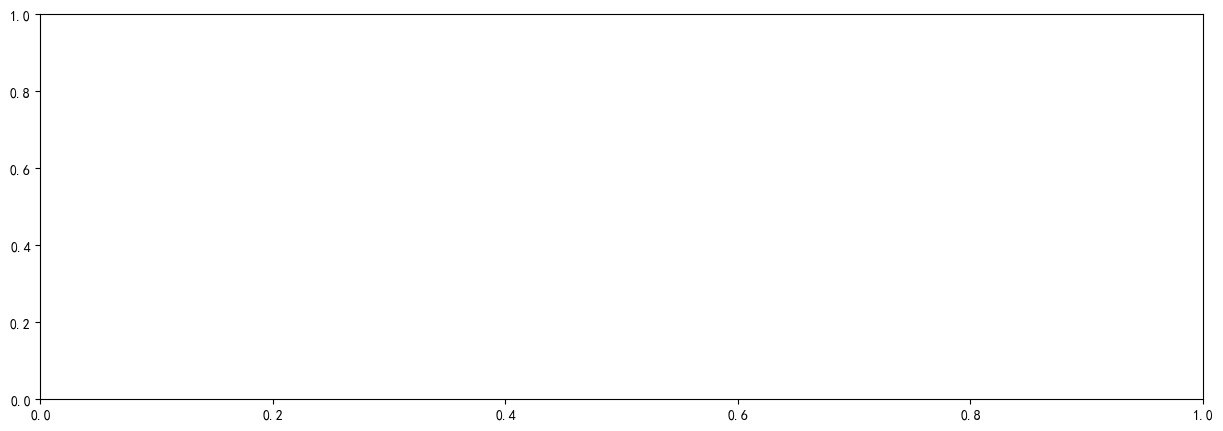

In [62]:
train_loss= pd.read_csv("result_data/get_V_loss.csv").iloc[:, 1]
plt.figure(figsize=(15,5))
plt.plot(range(100),train_loss,label="训练损失")
plt.xlabel("epoches")
plt.ylabel("MESloss")
plt.legend(loc='best')
plt.show()

In [63]:
Fnl=lstm_model(acc_vali.permute((0,2,1)).to("cuda"))
P_nl_total=torch.stack((acc[181:201,(num_step-1):].to("cuda"),Fnl[:,:,0]),dim=2)
P_tatol=torch.cat((torch.zeros([20,len(A_nl)-1,P_nl_total.shape[2]]).to("cuda"),P_nl_total),dim=1)
P_tatol=P_tatol.unsqueeze(1).permute(0,1,3,2)
V_nl=scl_model(P_tatol)
F_nl_re=V2Fnl(V_nl,yita)

In [64]:
Newmar_sultl=pd.read_csv("Newmark_beta_u_result_1000.csv").iloc[:,1:]
ETDM_Newton_result= pd.read_csv("result_data/ETDM_Newton_resutl.csv").iloc[:, 1]

FileNotFoundError: [Errno 2] No such file or directory: 'Newmark_beta_u_result_1000.csv'

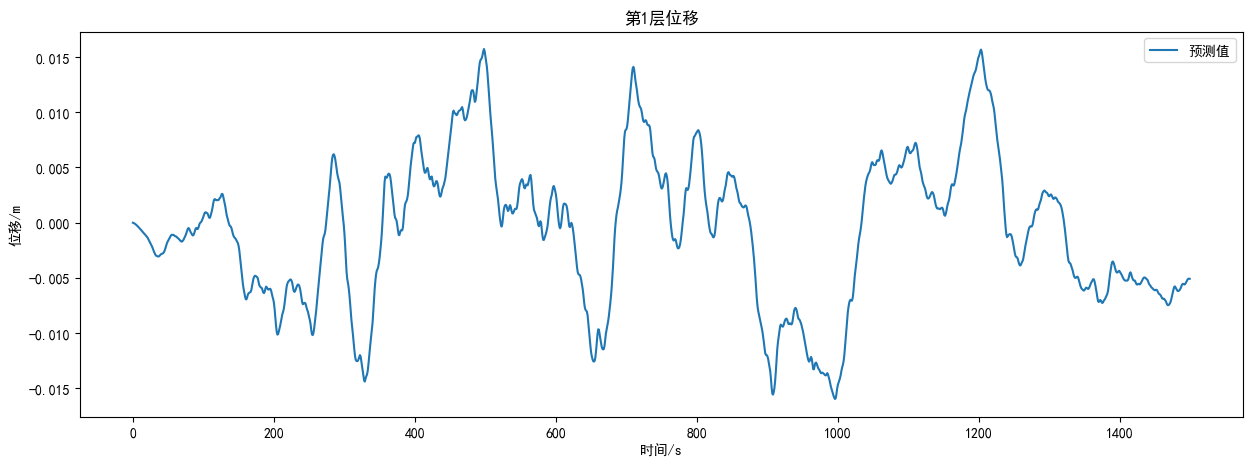

In [67]:
plt.figure(figsize=(15,5))
plt.plot(range(1500),V_nl[0,0,0,:].detach().cpu(),label="预测值")
# plt.plot(range(1500),-Newmar_sultl.iloc[0,num_step-1:],label="Newmark值")
plt.title("第1层位移")
plt.legend(loc='best')
plt.ylabel("位移/m")
plt.xlabel("时间/s")
plt.show()

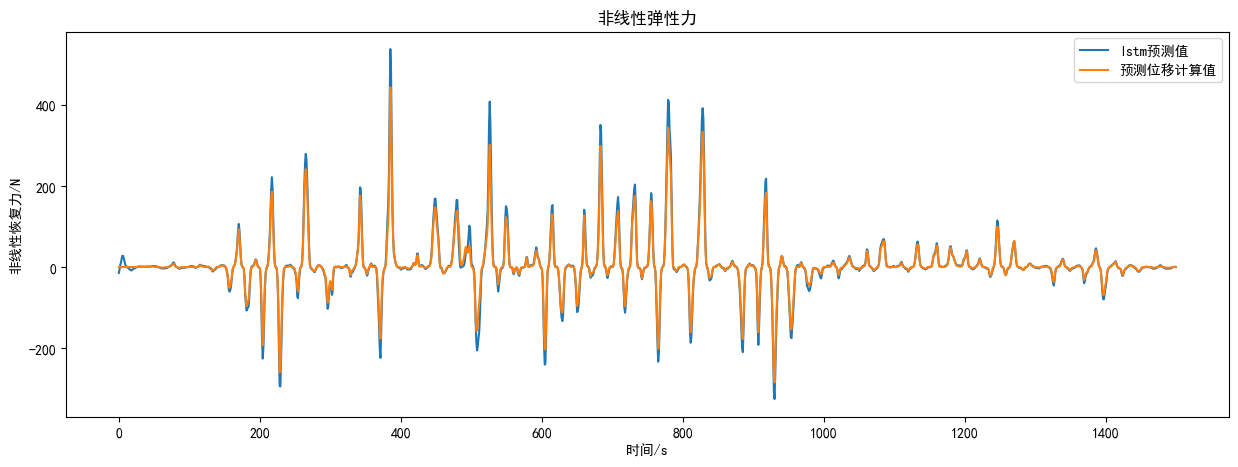

In [36]:
plt.figure(figsize=(15,5))
plt.plot(range(1500),Fnl.permute((0,2,1))[2,0,:].detach().cpu(),label="lstm预测值")
plt.plot(range(1500),F_nl_re[2,:].detach().cpu(),label="预测位移计算值")
plt.title("非线性弹性力")
plt.ylabel("非线性恢复力/N")
plt.xlabel("时间/s")
plt.legend(loc="best")
plt.show()

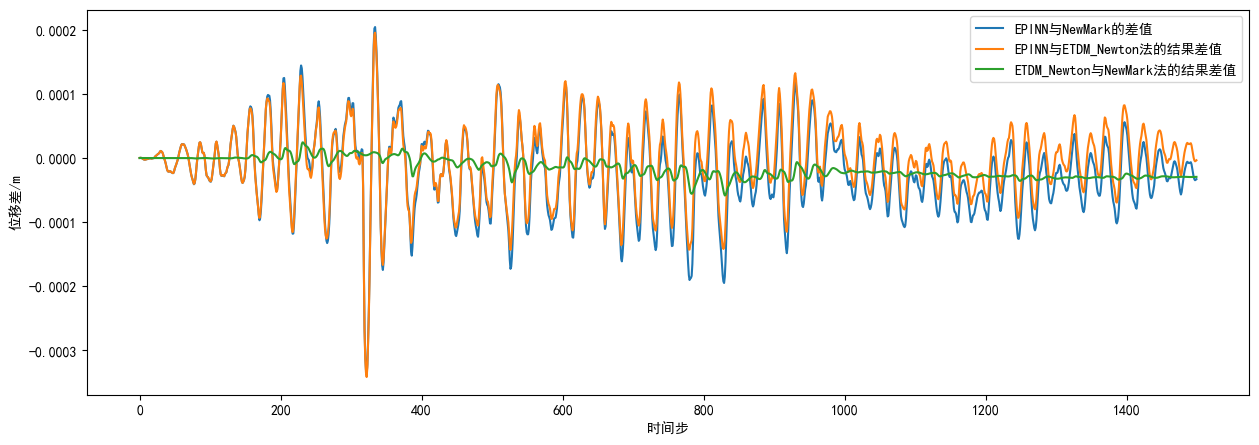

In [38]:
plt.figure(figsize=(15,5))
plt.plot(range(1500),(V_nl[0,0,0,:].detach().cpu()+Newmar_sultl.iloc[0,num_step-1:]),label="EPINN与NewMark的差值")
plt.plot(range(1500),(V_nl[0,0,0,:].detach().cpu()-ETDM_Newton_result.iloc[num_step-1:]),label="EPINN与ETDM_Newton法的结果差值")
plt.plot(range(1500),(np.array(Newmar_sultl.iloc[0,num_step-1:])+np.array(ETDM_Newton_result.iloc[num_step-1:])),label="ETDM_Newton与NewMark法的结果差值")
plt.legend(loc="best")
plt.xlabel("时间步")
plt.ylabel("位移差/m")
plt.show()